In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as signal
import imageio as io
from tqdm import tqdm
import pickle, re
import cv2
font = cv2.FONT_HERSHEY_SIMPLEX
rgb = (255, 255, 255)

import sys
sys.path.insert(1, '../numphly')
import numphly as nly
import tracker_decoder as tkr_dec
import mcam_tools
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


def check_characters(input_string, target_characters):
    return set(target_characters).issubset(set(input_string))


In [3]:
exp_target = 'R72'
gtype_name = ['R72A10xTRPA1','R72A10xW1118','W1118xTRPA1']
sex_name = ['female','male']
h5_dir = '../../FlyBehaviorSet/DLC_tracking/'+exp_target
output_fileloc = '../../FlyBehaviorSet/'
OG_recording_folder= 'original_recording_for_tracking/'+exp_target
converted_folder = 'Converted/R72/'
cropped_recording_folder= 'cropped_recording_for_tracking'  



dir_MCAM = '../DatastreamLine_MCAM_Tracking/'
scorer_floor  = 'DLC_resnet152_floor_topview_12label_1uniqueJan4shuffle1_100000'
scorer_wall   = 'DLC_resnet152_wall_sideview_7labelsJan1shuffle1_90000'
scorer_cross  = 'DLC_resnet152_wall_cross_section_view_8labelFeb19shuffle1_30000'
pcutoff = 0
frame_n = 126000
frame_rate = 60
frame_n_e = frame_rate*60*30
color_BP = [(0,0,255),(0,255,0),(255,0,0)]
arena_parameters = {
    'well_radius': 8.4,  # mm
    'food_cup_radius': 3.5,  # mm
}

experiments_index  = np.load('experiments_index.npy')
fileloc_set        = np.load('experiments_directory.npy')
num_file = len(fileloc_set)
videofile_set      = np.load('experiments_well_setup.npy')
num_well = len(videofile_set)
experiments_mscore = np.load('experiments_mscore.npy',allow_pickle='TRUE').item()
crop_h = np.load('crop_h.npy')
print(len(fileloc_set))


DLC_label_folder= 'DLC_label_ALL'
short_folder= 'short'

15


In [4]:
fileloc = fileloc_set[0]
experiment_index = experiments_index[0]
well = 'v_'+experiment_index+'_'+videofile_set[0]
numBP_floor = 12
numBP_wall  = 7
numBP_cross = 8
numUniq = 1

hfile_floor = h5_dir+'/'+well+scorer_floor+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_floor))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_floor];
bodyparts_floor = (bodyparts[0::3])

uniqueID = Dataframe.columns.get_level_values(1)[0:3*numBP_floor*3];
uniqueID = (uniqueID[0::3*numBP_floor])[2]
paint = Dataframe.columns.get_level_values(2)[0:3*numBP_floor*3];
paint = paint[3*numBP_floor*2]

hfile_wall = h5_dir+'/'+well+scorer_wall+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_wall))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_wall];
bodyparts_wall = (bodyparts[0::3])

hfile_cross = h5_dir+'/'+well+scorer_cross+'_el_filtered.h5'
Dataframe = pd.read_hdf(os.path.join(hfile_cross))
bodyparts = Dataframe.columns.get_level_values(2)[0:3*numBP_cross];
bodyparts_cross = (bodyparts[0::3])


animalID = Dataframe.columns.get_level_values(1)[0:3*numBP_cross*3];
animalID = (animalID[0::3*numBP_cross])#[0:2]
n_ID = len(animalID)



numBP_floor = 3
numBP_wall  = 3
numBP_cross = 4
bodyparts_floor = bodyparts_floor[[0,3,4]]
bodyparts_wall  = bodyparts_wall[[1,2,3]]
bodyparts_cross = bodyparts_cross[[0,3,4,7]]




# print(bodyparts_floor1)
print(uniqueID,paint)
print(bodyparts_floor, len(bodyparts_floor))
print(bodyparts_wall, len(bodyparts_wall))
print(bodyparts_cross, len(bodyparts_cross))
# print(animalID)

num_exp = 0
for i in range(num_file):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    for j in range(num_well):
        sex = sexes[j]

        if sex != -1:
            num_exp = num_exp+1
            
            
total_events = np.zeros((3,num_exp)).astype(int)
genders_status   = -np.ones((num_exp)).astype(int)
genotypes_status = -np.ones((num_exp)).astype(int)
radius = -np.ones((num_exp))

ii = 0
for i in range(num_file):
    experiment  = experiments_mscore[fileloc_set[i]]
    sexes       = experiment['sex']
    genotypes   = experiment['genotype']
    events_type = experiment['events type']
    events      = experiment['events']
    circle      = experiment['arena circle']
    experiment_index = experiments_index[i]
    for j in range(num_well):

        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
#         if sex == 0 and genotype == 2:
            event_ts   = events[j]
            event_type = events_type[j]
            well_arena = circle[j]

            n_event = len(event_ts)
            n_event_HB  = event_type==1
            n_event_UWE = event_type==2
            n_event_L   = event_type==3
            
            total_events[0,ii] = sum(n_event_HB)
            total_events[1,ii] = sum(n_event_UWE)
            total_events[2,ii] = sum(n_event_L)
            
            genders_status[ii] = sex
            genotypes_status[ii] = genotype
            radius[ii] = (np.mean(well_arena, axis = 0))[2]
#             print(experiment_index+'_'+videofile_set[j], total_events[0,ii], total_events[1,ii], total_events[2,ii])
            ii += 1




shared_data_folder = '../Shared_data/'
loaded_data = np.load(shared_data_folder+exp_target+'_bodysize_event.npz',)
#         d_f_ht_tracked = d_w_ht_tracked, 
#         d_w_ht_tracked = d_w_ht_tracked,
#         d_ht_tracked   = d_ht_tracked,
#         segment = segment
d_ht_tracked = loaded_data['d_ht_tracked']

d_size = np.max(d_ht_tracked,axis=1)
print(crop_h.shape, num_exp, d_size.shape )

single paint
Index(['head', 'center', 'tail'], dtype='object', name='bodyparts') 3
Index(['head', 'center', 'tail'], dtype='object', name='bodyparts') 3
Index(['top', 'left', 'right', 'down'], dtype='object', name='bodyparts') 4
(86, 3) 86 (86,)


# event_tracking_rate

In [4]:
np.set_printoptions(precision=2)
filter_status = '_filtered'


n_event_sel_trk_f     = np.zeros((num_exp,4))
n_event_sel_trk_m_L   = np.zeros((num_exp,4))
n_event_sel_trk_m_UWE = np.zeros((num_exp,4))

n_not_fulltracked = 0
t_tracked = np.zeros(num_exp)
win_h = 30

ii = 0
for i in range(num_file):
#     for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    events_types = experiment['events type']
    events = experiment['events']
    experiment_index = experiments_index[i]
    start_t = np.max(experiment['starting_time'])
    well_tracker_select = np.logical_and(np.arange(frame_n)>=start_t,np.arange(frame_n)<start_t+frame_n_e)
    well_tracker_select_Nan = ~well_tracker_select
    print('starting_time',start_t, np.sum(well_tracker_select))
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
#         if sex == 0 and genotype == 0:
#         if sex == 1 and genotype == 0:
            event_ts   = events[j]
            event_type = events_types[j]

            circle = crop_h[ii,:]
            d_xy = [576/2, 576/2]-circle[0:2]-48

            parameter_mm2p = (arena_parameters['well_radius']/circle[2])
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]

            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)

            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                npz_file_name = h5_dir+'/'+well+'_el'+filter_status+'.npz'
                loaded_data = np.load(npz_file_name)
                loc_temp          = loaded_data['loc_temp']
                fly_tracker_temp  = loaded_data['fly_tracker_temp']

                well_tracker = nly.tracking_analysis_2partsOrCr_loc(loc_temp)

                well_tracker_selected = np.logical_and(well_tracker, well_tracker_select)
                
                idx_frames = np.arange(frame_n)
                buffer = 2
                thr = 4
                n_event_sel_trk_f[ii,:], n_event_sel_trk_m_L[ii,:], n_event_sel_trk_m_UWE[ii,:] = (
                                                    mcam_tools.events_tracking_rate(
                                                            event_ts, event_type, sex, buffer, thr,
                                                            well_tracker,
                                                            well_tracker_select))
                            

                t_tracked[ii] =  np.sum(well_tracker)/frame_n
                print(well, np.sum(well_tracker),
                      "%.3f" %t_tracked[ii],
#                       "%.3f" %(np.sum(well_tracker_ct)/frame_n),
#                       "%.3f" %(np.sum(well_tracker_c)/frame_n),
                     )

            else:
                print('no h files')
            ii = ii+1

                    
                    
                    
n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f[genotypes_status==0,:], axis=0)
n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L[genotypes_status==0,:], axis=0)
n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE[genotypes_status==0,:], axis=0)

print('MVCA:',"%.4f" % np.mean(t_tracked[genotypes_status==0]), 'genotype:',0)

print("30 mins:")
print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,  "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

print("35 mins:")
print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))





n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f[genotypes_status==1,:], axis=0)
n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L[genotypes_status==1,:], axis=0)
n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE[genotypes_status==1,:], axis=0)

print('MVCA:',"%.4f" % np.mean(t_tracked[genotypes_status==1]), 'genotype:',1)

print("30 mins:")
print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,  "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

print("35 mins:")
print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))



n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f[genotypes_status==2,:], axis=0)
n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L[genotypes_status==2,:], axis=0)
n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE[genotypes_status==2,:], axis=0)

print('MVCA:',"%.4f" % np.mean(t_tracked[genotypes_status==2]), 'genotype:',2)

print("30 mins:")
print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,  "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

print("35 mins:")
print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))




n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f, axis=0)
n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L, axis=0)
n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE, axis=0)

print('MVCA:',"%.4f" % np.mean(t_tracked))

print("30 mins:")
print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,  "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

print("35 mins:")
print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))


starting_time 6409 108000
v_05_08_24_exp1_A1 99074 0.786
v_05_08_24_exp1_B1 115650 0.918
v_05_08_24_exp1_D1 94422 0.749
v_05_08_24_exp1_A2 119424 0.948
v_05_08_24_exp1_B2 102415 0.813
starting_time 5088 108000
v_05_08_24_exp2_C1 109112 0.866
v_05_08_24_exp2_D1 121039 0.961
v_05_08_24_exp2_A2 108157 0.858
v_05_08_24_exp2_B2 116175 0.922
v_05_08_24_exp2_D2 118586 0.941
starting_time 4885 108000
v_05_09_24_exp1_A1 110596 0.878
v_05_09_24_exp1_C1 109950 0.873
v_05_09_24_exp1_D1 113535 0.901
v_05_09_24_exp1_A2 116428 0.924
v_05_09_24_exp1_B2 117092 0.929
v_05_09_24_exp1_C2 122080 0.969
v_05_09_24_exp1_D2 123509 0.980
starting_time 3754 108000
v_05_09_24_exp2_B1 106275 0.843
v_05_09_24_exp2_C1 121383 0.963
v_05_09_24_exp2_D1 116331 0.923
v_05_09_24_exp2_A2 118940 0.944
starting_time 4868 108000
v_05_13_24_exp1_A1 105830 0.840
v_05_13_24_exp1_D1 115828 0.919
v_05_13_24_exp1_A2 122024 0.968
v_05_13_24_exp1_B2 120117 0.953
v_05_13_24_exp1_D2 116766 0.927
starting_time 3862 108000
v_05_13_24_exp

# Floor and Wall

In [19]:
np.set_printoptions(precision=2)
filter_status = '_filtered'
n_event_tracked_f = np.zeros(4)
n_event_tracked_m_L  = np.zeros(4)
n_event_tracked_m_UWE = np.zeros(4)

n_event_selected_f = np.zeros(4)
n_event_selected_f_m_L  = np.zeros(4)
n_event_selected_m_UWE = np.zeros(4)

n_event_f = 0
n_event_m_L = 0
n_event_m_UWE = 0 
n_not_fulltracked = 0
t_tracked = np.zeros(num_exp)
win_h = 30
loc_HB    = np.empty((0, 2,4,2,win_h*2))
d_f1f2_HB = np.empty((0, win_h*2))
d_f1f2_ct_HB  = np.empty((0, win_h*2))
d_f1f2_random = np.empty((0, win_h*2))
d_f1f2_c_HB   = np.empty((0, win_h*2))
d_f1f2_t_HB   = np.empty((0, win_h*2))
ii = 0
for i in range(num_file):
#     for i in range(5):
    experiment = experiments_mscore[fileloc_set[i]]
    sexes        = experiment['sex']
    genotypes   = experiment['genotype']
    experiment_type = experiment['events type']
    events = experiment['events']
    experiment_index = experiments_index[i]
    start_t = np.max(experiment['starting_time'])
    well_tracker_select = np.logical_and(np.arange(frame_n)>=start_t,np.arange(frame_n)<start_t+frame_n_e)
    well_tracker_select_Nan = ~well_tracker_select
    print('starting_time',start_t, np.sum(well_tracker_select))
    for j in range(num_well):
#     for j in range(1):
        sex = sexes[j]
        genotype = genotypes[j]

        if sex != -1:
            event_ts   = events[j]
            event_type = experiment_type[j]

            circle = crop_h[ii,:]
            d_xy = [576/2, 576/2]-circle[0:2]-48

            parameter_mm2p = (17.4625/circle[2]/2)
            n_event = len(event_ts)
            well = 'v_'+experiment_index+'_'+videofile_set[j]

            hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
            my_file_wall = Path(hfile_wall)
            hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
            my_file_floor = Path(hfile_floor)
            hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
            my_file_cross = Path(hfile_cross)

            wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
            wall_floor_cross = wall_floor and my_file_cross.is_file()
            if wall_floor_cross:
                npz_file_name = h5_dir+'/'+well+'_el'+filter_status+'.npz'
                loaded_data = np.load(npz_file_name)
                loc_temp          = loaded_data['loc_temp']
                fly_tracker_temp  = loaded_data['fly_tracker_temp']
                well_tracker_temp = loaded_data['well_tracker_temp']
                well_tracker = nly.tracking_analysis_body_center(fly_tracker_temp)
                Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)

                loc_m_hct = np.mean(loc_temp[:,0:3,:,:], axis=1)
                fly_tracker_hct = ~np.isnan(loc_m_hct[:,0,:])
                loc_m_ht = np.mean(loc_temp[:,[0,2],:,:], axis=1)
                fly_tracker_ht = ~np.isnan(loc_m_ht[:,0,:])
                loc_m_c  = loc_temp[:,1,:,:]
                fly_tracker_c = ~np.isnan(loc_m_c[:,0,:])
                loc_m_cr = loc_temp[:,3,:,:]
                fly_tracker_cr = ~np.isnan(loc_m_cr[:,0,:])
                loc_m_parts = np.stack([loc_m_ht, loc_m_c, loc_m_cr], axis=1)
                
                loc_temp_m = np.zeros((2,2,frame_n))
                
                loc_temp_m[:,:,:] = loc_m_hct
                fly_tracker_ht_fill = np.logical_and(fly_tracker_ht, ~fly_tracker_hct)
                loc_temp_m[0,:,fly_tracker_ht_fill[0,:]] = loc_m_ht[0,:,fly_tracker_ht_fill[0,:]]
                loc_temp_m[1,:,fly_tracker_ht_fill[1,:]] = loc_m_ht[1,:,fly_tracker_ht_fill[1,:]]
                
                
                fly_tracker_c_fill =np.logical_and(fly_tracker_c, ~fly_tracker_ht)
                loc_temp_m[0,:,fly_tracker_c_fill[0,:]] = loc_m_c[0,:,fly_tracker_c_fill[0,:]]
                loc_temp_m[1,:,fly_tracker_c_fill[1,:]] = loc_m_c[1,:,fly_tracker_c_fill[1,:]]
                
                fly_tracker_cr_fill = np.logical_and(fly_tracker_cr,      ~fly_tracker_ht)
                fly_tracker_cr_fill = np.logical_and(fly_tracker_cr_fill, ~fly_tracker_c)
                loc_temp_m[0,:,fly_tracker_cr_fill[0,:]] = loc_m_cr[0,:,fly_tracker_cr_fill[0,:]]
                loc_temp_m[1,:,fly_tracker_cr_fill[1,:]] = loc_m_cr[1,:,fly_tracker_cr_fill[1,:]]
                
                #
#                 loc_temp_m = np.nanmean(loc_m_parts, axis=1)
                
                loc_temp_ct_m  = np.mean(loc_temp[:,[1,2],:,:], axis=1)
                
                #speed
                d_loc_df = np.sqrt(np.sum(np.square(np.diff(loc_temp_m,axis=2)),axis=1)) 
                #fly pair average distance
                d_f1f2    = np.sqrt(np.sum(np.square(np.diff(loc_temp_m,axis=0)),axis=1))
                d_f1f2_ct = np.sqrt(np.sum(np.square(np.diff(loc_temp_ct_m,axis=0)),axis=1))
                d_f1f2_c  = np.sqrt(np.sum(np.square(np.diff(loc_m_c,axis=0)),axis=1))
                d_f1f2_t  = np.sqrt(np.sum(np.square(np.diff(loc_temp[:,2,:,:],axis=0)),axis=1))
                well_tracker_ct = d_f1f2_ct>-1
                well_tracker_c  = d_f1f2_c>-1
                

                idx_frames = np.arange(frame_n)
                idx_frames_tk = idx_frames[well_tracker]
                idx_frames_tk = idx_frames_tk[np.logical_and(idx_frames_tk>win_h, idx_frames_tk<frame_n-win_h)]
                np.random.shuffle(idx_frames_tk)
                for i_random in idx_frames_tk[0:15]:
                    d_f1f2_random = np.vstack((d_f1f2_random,d_f1f2[0,i_random-win_h:i_random+win_h]))
                
                

                if sex == 0:
                    if sum(event_type == 1)>0:
                        event_ts_HB = event_ts[event_type==1]
                        n_event = len(event_ts_HB)
                        if n_event > 0:
                            count_event_tracker = np.zeros(n_event)
                            for dt in np.arange(-2,3):
                                event_tracker = well_tracker[event_ts_HB+dt]
                                count_event_tracker += event_tracker
                            event_tracker_dt = count_event_tracker >= 4
                            event_ts_HB_tracked = event_ts_HB[event_tracker_dt]
                            n_event_tracked_f[0] = n_event_tracked_f[0] +sum(well_tracker[event_ts_HB])
                            n_event_tracked_f[1] = n_event_tracked_f[1] +sum(well_tracker_ct[0,event_ts_HB])
                            n_event_tracked_f[2] = n_event_tracked_f[2] +sum(well_tracker_c[0,event_ts_HB])
                            n_event_tracked_f[3] = n_event_tracked_f[3] +sum(well_tracker[event_ts_HB_tracked])
                            n_event_f  = n_event_f +n_event
                            for i_event in range(n_event):
                                t_i = event_ts_HB[i_event]
                                loc_event = np.zeros((1,2,4,2,win_h*2))
                                
                                if t_i+win_h<=frame_n:
                                    loc_event[0,:,:,:,:] = loc_temp[:,:,:,t_i-win_h:t_i+win_h]
                                    d_f1f2_HB    = np.vstack((d_f1f2_HB,    d_f1f2[0,t_i-win_h:t_i+win_h]))
                                    d_f1f2_ct_HB = np.vstack((d_f1f2_ct_HB, d_f1f2_ct[0,t_i-win_h:t_i+win_h]))
                                    d_f1f2_c_HB  = np.vstack((d_f1f2_c_HB, d_f1f2_c[0,t_i-win_h:t_i+win_h]))
                                    d_f1f2_t_HB  = np.vstack((d_f1f2_t_HB, d_f1f2_t[0,t_i-win_h:t_i+win_h]))
                                else:
                                    d_f1f2_temp = np.zeros((1, win_h*2))
                                    loc_event[0,:,:,:,:] = np.NaN
                                    loc_event[0,:,:,:,0:frame_n-(t_i-win_h)]= loc_temp[:,:,:,(t_i-win_h):frame_n]
                                    d_f1f2_temp[0,:] = np.NaN
                                    d_f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2[0,t_i-win_h:frame_n]
                                    d_f1f2_HB    = np.vstack((d_f1f2_HB,    d_f1f2_temp))
                                    d_f1f2_temp[0,:] = np.NaN
                                    d_f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2_ct[0,t_i-win_h:frame_n]                                  
                                    d_f1f2_ct_HB = np.vstack((d_f1f2_ct_HB, d_f1f2_temp))
                                    d_f1f2_temp[0,:] = np.NaN
                                    d_f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2_c[0,t_i-win_h:frame_n]
                                    d_f1f2_c_HB  = np.vstack((d_f1f2_c_HB, d_f1f2_temp))
                                    d_f1f2_temp[0,:] = np.NaN
                                    d_f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2_t[0,t_i-win_h:frame_n]   
                                    d_f1f2_t_HB  = np.vstack((d_f1f2_t_HB, d_f1f2_temp))
                                    
                                loc_HB = np.concatenate([loc_HB, loc_event], axis=0)

                elif sex == 1:
                    if sum(event_type == 3)>0:
                        event_ts_L = event_ts[event_type==3]
                        n_event = len(event_ts_L)
                        if n_event > 0:
                            count_event_tracker = np.zeros(n_event)
                            for dt in np.arange(-2,3):
                                event_tracker = well_tracker[event_ts_L+dt]
                                count_event_tracker += event_tracker
                            event_tracker_dt = count_event_tracker >= 4
                            event_ts_L_tracked = event_ts_L[event_tracker_dt]
                            n_event_tracked_m_L[0]  = n_event_tracked_m_L[0] +sum(well_tracker[event_ts_L])
                            n_event_tracked_m_L[1]  = n_event_tracked_m_L[1] +sum(well_tracker_ct[0,event_ts_L])
                            n_event_tracked_m_L[2]  = n_event_tracked_m_L[2] +sum(well_tracker_c[0,event_ts_L])
                            n_event_tracked_m_L[3]  = n_event_tracked_m_L[3] +sum(well_tracker[event_ts_L_tracked])
                            n_event_m_L  = n_event_m_L +n_event
                    if sum(event_type == 2)>0:
                        event_ts_UWE = event_ts[event_type==2]
                        n_event = len(event_ts_UWE)
                        if n_event > 0:
                            count_event_tracker = np.zeros(n_event)
                            for dt in np.arange(-2,3):
                                event_tracker = well_tracker[event_ts_UWE+dt]
                                count_event_tracker += event_tracker
                            event_tracker_dt = count_event_tracker >= 4
                            event_ts_UWE_tracked = event_ts_UWE[event_tracker_dt]
                            n_event_tracked_m_UWE[0] = n_event_tracked_m_UWE[0]+sum(well_tracker[event_ts_UWE])
                            n_event_tracked_m_UWE[1] = n_event_tracked_m_UWE[1]+sum(well_tracker_ct[0,event_ts_UWE])
                            n_event_tracked_m_UWE[2] = n_event_tracked_m_UWE[2]+sum(well_tracker_c[0,event_ts_UWE])
                            n_event_tracked_m_UWE[3] = n_event_tracked_m_UWE[3] +sum(well_tracker[event_ts_UWE_tracked])
                            n_event_m_UWE  = n_event_m_UWE +n_event
                t_tracked[ii] =  np.sum(well_tracker)/frame_n
                print(well, np.sum(well_tracker),
                      "%.3f" %t_tracked[ii],
                      "%.3f" %(np.sum(well_tracker_ct)/frame_n),
                      "%.3f" %(np.sum(well_tracker_c)/frame_n),
                     )

            else:
                print('no h files')
            ii = ii+1
print(d_f1f2_HB.shape, d_f1f2_random.shape)
print('floor and wall and cross detection: ',"%.3f" % np.mean(t_tracked))
print('F HBT',n_event_tracked_f[0],     n_event_f ,     "%.3f" % (n_event_tracked_f[0] /n_event_f))
print('M LGE',n_event_tracked_m_L[0],   n_event_m_L ,   "%.3f" % (n_event_tracked_m_L[0] /n_event_m_L))
print('M UWE',n_event_tracked_m_UWE[0], n_event_m_UWE ,"%.3f" % (n_event_tracked_m_UWE[0] /n_event_m_UWE))

print('F HBT',n_event_tracked_f[1],     n_event_f ,     "%.3f" % (n_event_tracked_f[1] /n_event_f))
print('M LGE',n_event_tracked_m_L[1],   n_event_m_L ,   "%.3f" % (n_event_tracked_m_L[1] /n_event_m_L))
print('M UWE',n_event_tracked_m_UWE[1], n_event_m_UWE ,"%.3f" % (n_event_tracked_m_UWE[1] /n_event_m_UWE))

print('F HBT',n_event_tracked_f[2],     n_event_f ,     "%.3f" % (n_event_tracked_f[2] /n_event_f))
print('M LGE',n_event_tracked_m_L[2],   n_event_m_L ,   "%.3f" % (n_event_tracked_m_L[2] /n_event_m_L))
print('M UWE',n_event_tracked_m_UWE[2], n_event_m_UWE ,"%.3f" % (n_event_tracked_m_UWE[2] /n_event_m_UWE))

print('')
print('F HBT',n_event_tracked_f[3],     n_event_f ,     "%.3f" % (n_event_tracked_f[3] /n_event_f))
print('M LGE',n_event_tracked_m_L[3],   n_event_m_L ,   "%.3f" % (n_event_tracked_m_L[3] /n_event_m_L))
print('M UWE',n_event_tracked_m_UWE[3], n_event_m_UWE ,"%.3f" % (n_event_tracked_m_UWE[3] /n_event_m_UWE))

starting_time 6409 108000
(1, 126000)
v_05_08_24_exp1_A1 110753 0.879 0.391 0.432
(1, 126000)
v_05_08_24_exp1_B1 118569 0.941 0.720 0.745
(1, 126000)
v_05_08_24_exp1_D1 96956 0.769 0.577 0.599
(1, 126000)
v_05_08_24_exp1_A2 121394 0.963 0.575 0.687
(1, 126000)
v_05_08_24_exp1_B2 111219 0.883 0.323 0.457
starting_time 5088 108000
(1, 126000)
v_05_08_24_exp2_C1 112649 0.894 0.768 0.843
(1, 126000)
v_05_08_24_exp2_D1 121907 0.968 0.848 0.873
(1, 126000)
v_05_08_24_exp2_A2 112260 0.891 0.718 0.795
(1, 126000)
v_05_08_24_exp2_B2 118752 0.942 0.761 0.782
(1, 126000)
v_05_08_24_exp2_D2 120168 0.954 0.790 0.820
starting_time 4885 108000
(1, 126000)
v_05_09_24_exp1_A1 112389 0.892 0.788 0.812
(1, 126000)
v_05_09_24_exp1_C1 114299 0.907 0.618 0.650
(1, 126000)
v_05_09_24_exp1_D1 115744 0.919 0.711 0.738
(1, 126000)
v_05_09_24_exp1_A2 117689 0.934 0.839 0.862
(1, 126000)
v_05_09_24_exp1_B2 120617 0.957 0.676 0.719
(1, 126000)
v_05_09_24_exp1_C2 122603 0.973 0.887 0.899
(1, 126000)
v_05_09_24_exp1

KeyboardInterrupt: 

# non filtered
### floor and wall and cross detection:  0.894
### F HBT 1079.0 1105 0.976
### M LGE 496.0 510 0.973
### M UWE 570.0 586 0.973
F HBT 1063.0 1105 0.962
M LGE 472.0 510 0.925
M UWE 538.0 586 0.918
F HBT 1018.0 1105 0.921
M LGE 439.0 510 0.861
M UWE 501.0 586 0.855
F HBT 1045.0 1105 0.946
M LGE 453.0 510 0.888
M UWE 511.0 586 0.872

In [12]:
print(np.random.randint(0,10))

5


(1105, 60) (1105, 60) (1290, 60) (60,)
(60,)



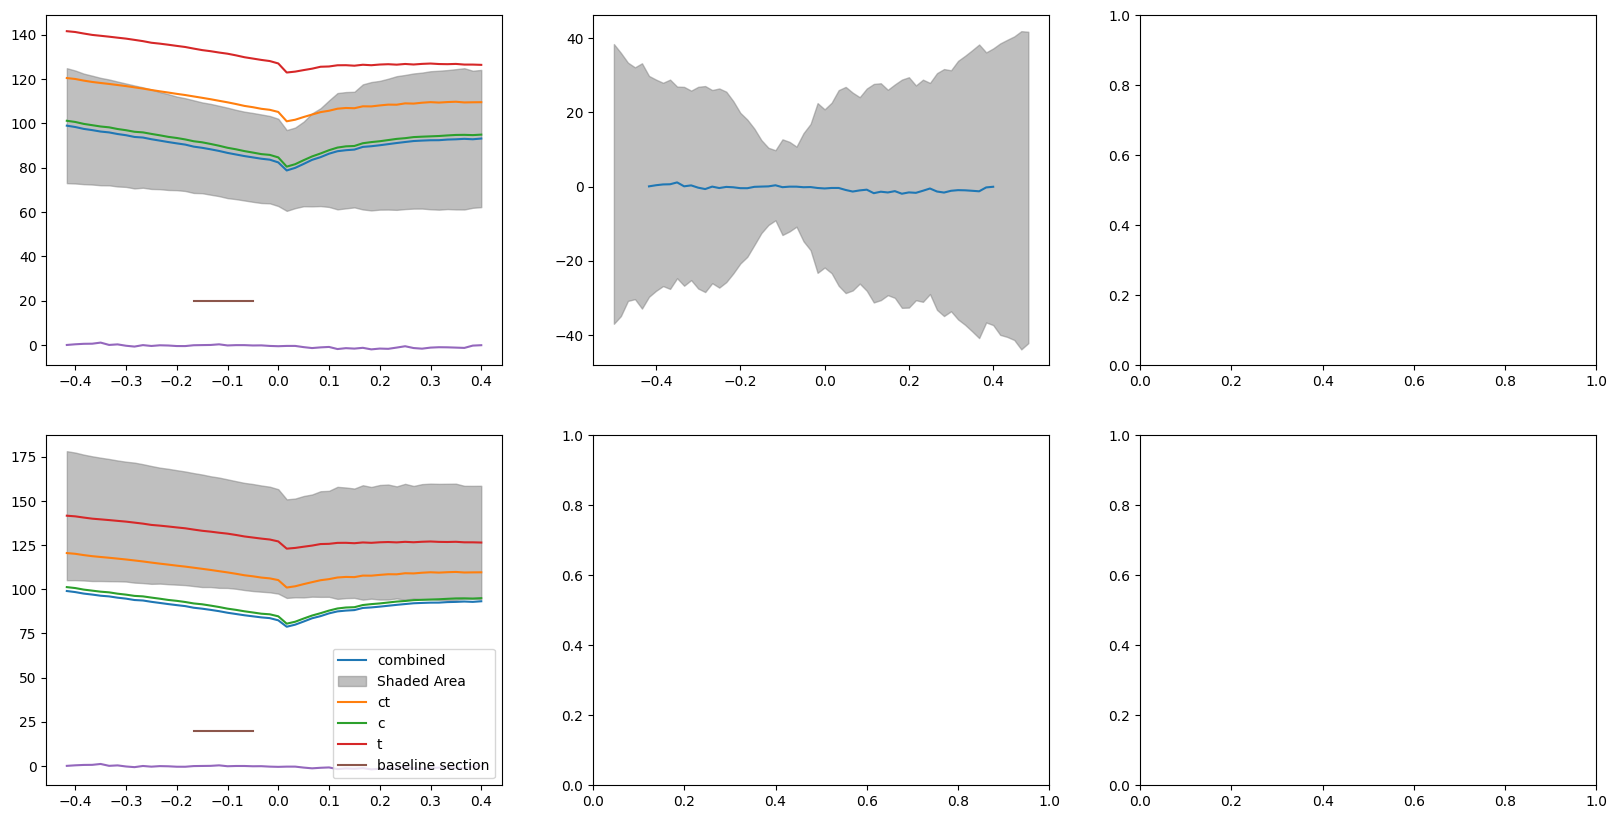

In [13]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('R72A10', fontsize=20)
fontsize = 15
ms = 10
np.set_printoptions(precision=3)
sex_color   = ['r','b']
gtype_marker = ['x','^','.']
t_window = np.arange(-win_h,win_h)/frame_rate
n_HB = d_f1f2_HB.shape[0]
print(d_f1f2_HB.shape, d_f1f2_ct_HB.shape, d_f1f2_random.shape, t_window.shape)


section_d_baseline = np.arange(win_h-10,win_h-2)

d_f1f2_HB_norm = np.zeros(d_f1f2_HB.shape)
d_f1f2_HB_m    = np.nanmean(d_f1f2_HB[:,section_d_baseline],axis=1)
d_f1f2_ct_HB_norm = np.zeros(d_f1f2_ct_HB.shape)
d_f1f2_ct_HB_m    = np.nanmean(d_f1f2_ct_HB[:,section_d_baseline],axis=1)
d_f1f2_c_HB_norm = np.zeros(d_f1f2_c_HB.shape)
d_f1f2_c_HB_m    = np.nanmean(d_f1f2_c_HB[:,section_d_baseline],axis=1)
d_f1f2_t_HB_norm = np.zeros(d_f1f2_t_HB.shape)
d_f1f2_t_HB_m    = np.nanmean(d_f1f2_t_HB[:,section_d_baseline],axis=1)
for i in range(n_HB):
    d_f1f2_HB_norm[i,:]    = d_f1f2_HB[i,:] #- d_f1f2_HB_m[i]
    d_f1f2_ct_HB_norm[i,:] = d_f1f2_ct_HB[i,:] #- d_f1f2_ct_HB_m[i]
    d_f1f2_c_HB_norm[i,:]  = d_f1f2_c_HB[i,:] #- d_f1f2_c_HB_m[i]
    d_f1f2_t_HB_norm[i,:]  = d_f1f2_t_HB[i,:] #- d_f1f2_t_HB_m[i]

    
    
n_random = d_f1f2_random.shape[0]
d_f1f2_random_norm = np.zeros(d_f1f2_random.shape)
d_f1f2_random_m    = np.nanmean(d_f1f2_random[:,section_d_baseline],axis=1)  
for i in range(n_random):
    d_f1f2_random_norm[i,:] = d_f1f2_random[i,:] - d_f1f2_random_m[i]

    
window_str = ['60hz \n no downsampling', '30hz', '10hz', '2hz','1hz', '0.5hz']

n_random = d_f1f2_random.shape[0]

d_d_f1f2_HB    = (np.diff(d_f1f2_HB,axis = 1))
d_d_f1f2_ct_HB = (np.diff(d_f1f2_ct_HB,axis = 1))
d_d_f1f2_c_HB  = (np.diff(d_f1f2_c_HB,axis = 1))

d_d_d_f1f2_HB    = (np.diff(d_d_f1f2_HB,axis = 1))
d_d_d_f1f2_ct_HB = (np.diff(d_d_f1f2_ct_HB,axis = 1))
d_d_d_f1f2_c_HB  = (np.diff(d_d_f1f2_c_HB,axis = 1))

section = np.arange(win_h-25,win_h+25)
d_f1f2_HB_norm_m   = np.nanmean(d_f1f2_HB_norm,axis=0)
d_f1f2_HB_norm_s   = np.nanstd(d_f1f2_HB_norm,axis=0)
d_f1f2_t_HB_norm_m = np.nanmean(d_f1f2_t_HB_norm,axis=0)
d_f1f2_t_HB_norm_s = np.nanstd(d_f1f2_t_HB_norm,axis=0)

print(d_f1f2_HB_norm_s.shape)
axs[0,0].plot(t_window[section], d_f1f2_HB_norm_m[section], '-', label = 'combined')


axs[0,0].fill_between(t_window[section],
                      (d_f1f2_HB_norm_m-d_f1f2_HB_norm_s)[section],
                      (d_f1f2_HB_norm_m+d_f1f2_HB_norm_s)[section],
                      color='gray', alpha=0.5, label='Shaded Area')


axs[0,0].plot(t_window[section], np.nanmean(d_f1f2_ct_HB_norm[:,section],axis=0), '-', label = 'ct')
axs[0,0].plot(t_window[section], np.nanmean(d_f1f2_c_HB_norm[:,section],axis=0), '-', label = 'c')
axs[0,0].plot(t_window[section], d_f1f2_t_HB_norm_m[section], '-', label = 't')
axs[0,0].plot(t_window[section], np.nanmean(d_f1f2_random_norm[:,section],axis=0), '-')
axs[0,0].plot(t_window[section_d_baseline[[0,-1]]],[20,20], label = 'baseline section')
# axs[0,0].legend()



axs[1,0].plot(t_window[section], d_f1f2_HB_norm_m[section], '-', label = 'combined')
axs[1,0].fill_between(t_window[section],
                      (d_f1f2_t_HB_norm_m-d_f1f2_t_HB_norm_s)[section],
                      (d_f1f2_t_HB_norm_m+d_f1f2_t_HB_norm_s)[section],
                      color='gray', alpha=0.5, label='Shaded Area')

axs[1,0].plot(t_window[section], np.nanmean(d_f1f2_ct_HB_norm[:,section],axis=0), '-', label = 'ct')
axs[1,0].plot(t_window[section], np.nanmean(d_f1f2_c_HB_norm[:,section],axis=0), '-', label = 'c')
axs[1,0].plot(t_window[section], d_f1f2_t_HB_norm_m[section], '-', label = 't')
axs[1,0].plot(t_window[section], np.nanmean(d_f1f2_random_norm[:,section],axis=0), '-')
axs[1,0].plot(t_window[section_d_baseline[[0,-1]]],[20,20], label = 'baseline section')
axs[1,0].legend()

d_f1f2_random_norm_m = np.nanmean(d_f1f2_random_norm,axis=0)
d_f1f2_random_norm_s = np.nanstd(d_f1f2_random_norm,axis=0)
axs[0,1].plot(t_window[section], np.nanmean(d_f1f2_random_norm[:,section],axis=0), '-')

axs[0,1].fill_between(t_window, d_f1f2_random_norm_m-d_f1f2_random_norm_s, d_f1f2_random_norm_m+d_f1f2_random_norm_s,
                      color='gray', alpha=0.5, label='Shaded Area')



# axs[0,0].set_ylim([-30,30])
# axs[0,1].set_ylim([-30,30])
# axs[1,0].set_ylim([-30,30])
# for i in range(n_HB):
#     axs[0,0].plot(t_window[section], d_f1f2_HB_norm[i,section], '-')
#     axs[1,0].plot(t_window[section], d_d_f1f2_ct_HB[i,section], '-')
#     axs[2,0].plot(t_window[section], d_d_f1f2_c_HB[i,section], '-')
    
#     axs[0,1].plot(t_window[section], d_d_d_f1f2_HB[i,section], '-')
#     axs[1,1].plot(t_window[section], d_d_d_f1f2_ct_HB[i,section], '-')
#     axs[2,1].plot(t_window[section], d_d_d_f1f2_c_HB[i,section], '-')


# axs[0,0].plot(t_window[section], d_f1f2_HB[i,section], '-')
# axs[1,0].plot(t_window[section], d_f1f2_ct_HB[i,section], '-')
# axs[2,0].plot(t_window[section], d_f1f2_c_HB[i,section], '-')

# axs[0,1].plot(t_window[section], d_d_f1f2_HB[i,section], '-')
# axs[1,1].plot(t_window[section], d_d_f1f2_ct_HB[i,section], '-')
# axs[2,1].plot(t_window[section], d_d_f1f2_c_HB[i,section], '-')




# for i in range(n_HB):
#     axs[0,0].plot(t_window[section], d_d_f1f2_HB[i,section], '-')
#     axs[1,0].plot(t_window[section], d_d_f1f2_ct_HB[i,section], '-')
#     axs[2,0].plot(t_window[section], d_d_f1f2_c_HB[i,section], '-')
    
#     axs[0,1].plot(t_window[section], d_d_d_f1f2_HB[i,section], '-')
#     axs[1,1].plot(t_window[section], d_d_d_f1f2_ct_HB[i,section], '-')
#     axs[2,1].plot(t_window[section], d_d_d_f1f2_c_HB[i,section], '-')



# # for i in range(n_random):
# #     axs[0,1].plot(t_window[section], (np.diff(d_f1f2_random[i,:]))[section], '.')
    
# axs[0,0].set_ylim([-100,100])
# axs[1,0].set_ylim([-100,100])
# axs[2,0].set_ylim([-100,100])
# axs[0,1].set_ylim([-100,100])
# axs[1,1].set_ylim([-100,100])
# axs[2,1].set_ylim([-100,100])

print()


In [14]:
def filter_loc_HBorL(loc, thr_TT, d_d_threshold, thr_HC, buffer):
    
    Head1   = np.squeeze(loc[0,0,:,:])
    Center1 = np.squeeze(loc[0,1,:,:])
    Tail1   = np.squeeze(loc[0,2,:,:])
    Head2   = np.squeeze(loc[1,0,:,:])
    Center2 = np.squeeze(loc[1,1,:,:])
    Tail2   = np.squeeze(loc[1,2,:,:])
    
    s_Head1   = np.sqrt(np.sum(np.square(np.diff(Head1,axis=1)),axis=0))
    s_Head2   = np.sqrt(np.sum(np.square(np.diff(Head2,axis=1)),axis=0))
    s_Center1 = np.sqrt(np.sum(np.square(np.diff(Center1,axis=1)),axis=0))
    s_Center2 = np.sqrt(np.sum(np.square(np.diff(Center2,axis=1)),axis=0))
    s_Tail1   = np.sqrt(np.sum(np.square(np.diff(Tail1,axis=1)),axis=0))
    s_Tail2   = np.sqrt(np.sum(np.square(np.diff(Tail2,axis=1)),axis=0))
    
    s_tracker_H = np.logical_or(s_Head1  >=np.abs(d_d_threshold), s_Head2  >=np.abs(d_d_threshold))
    s_tracker_T = np.logical_or(s_Tail1  >=np.abs(d_d_threshold), s_Tail2  >=np.abs(d_d_threshold))
    s_tracker_C = np.logical_or(s_Center1>=np.abs(d_d_threshold), s_Center2>=np.abs(d_d_threshold))
    #single head part speed is higher than a threshold
    s_tracker = np.logical_or(np.logical_or(s_tracker_H,s_tracker_T),s_tracker_C)
    
    
    d_T1T2 = np.sqrt(np.sum(np.square(Tail1-Tail2),axis=0))
    d_H1H2 = np.sqrt(np.sum(np.square(Head1-Head2),axis=0))
    d_C1C2 = np.sqrt(np.sum(np.square(Center1-Center2),axis=0))
    
    d_H1C2 = np.sqrt(np.sum(np.square(Head1-Center2),axis=0))
    d_H2C1 = np.sqrt(np.sum(np.square(Head2-Center1),axis=0))
    d_H1T2 = np.sqrt(np.sum(np.square(Head1-Tail2),axis=0))
    d_H2T1 = np.sqrt(np.sum(np.square(Head2-Tail1),axis=0))

    idx_frame   = np.arange(len(d_T1T2))
    dis_tracker_HC = np.logical_or(d_H1C2<thr_HC, d_H2C1<thr_HC)
    dis_tracker_HT = np.logical_or(d_H1T2<thr_HC, d_H2T1<thr_HC)
    dis_tracker    = np.logical_or(dis_tracker_HC, dis_tracker_HT)
    dis_tracker    = np.logical_or(dis_tracker, d_H1H2<thr_HC)
    dis_tracker    = np.logical_or(dis_tracker, d_C1C2<thr_HC)
    
    dis_tracker    = np.logical_and(dis_tracker, d_T1T2>thr_TT)
    
    # same body part distance between 2 flies
    d_loc = np.sqrt(np.sum(np.square(np.diff(loc,axis=0)),axis=2))
    # same body part distance change between 2 frames
    d_d_loc = np.diff(np.squeeze(d_loc),axis=1)

    
    d_d_T1T2 = np.diff(d_T1T2)
    d_d_H1H2 = np.diff(d_H1H2)
    d_d_C1C2 = np.diff(d_C1C2)
    
    d_d_H1C2 = np.diff(d_H1C2)
    d_d_H2C1 = np.diff(d_H2C1)
    d_d_H1T2 = np.diff(d_H1T2)
    d_d_H2T1 = np.diff(d_H2T1)
    
    dd_tracker_HC   = np.logical_or(d_d_H1C2<=d_d_threshold, d_d_H2C1<=d_d_threshold)
    dd_tracker_HT   = np.logical_or(d_d_H1T2<=d_d_threshold, d_d_H2T1<=d_d_threshold)
    dd_tracker_H_CT = np.logical_or(dd_tracker_HC, dd_tracker_HT)
    
    
    dd_tracker_TT_HH    = np.logical_or(d_d_T1T2<=d_d_threshold,  d_d_H1H2<=d_d_threshold)
    dd_tracker_TT_HH_CC = np.logical_or(d_d_C1C2<=d_d_threshold, dd_tracker_TT_HH)
    dd_tracker = np.logical_or(dd_tracker_TT_HH_CC, dd_tracker_H_CT)
    dd_tracker = np.logical_or(dd_tracker, s_tracker)
    
    dd_tracker = np.logical_and(dis_tracker[:-1], dd_tracker)


    # frames where flies are close enough
    idx_frame_dd = (idx_frame[:-1])[dd_tracker]
    # frames where flies are tracked
#     idx_frame_tracked = idx_frame[well_tracker]
#     NaN_gaps      = np.diff(idx_frame_tracked)
#     idx_frame_gap =(idx_frame_tracked[:-1])[np.logical_and(NaN_gaps>=2, NaN_gaps<=3)]
#     idx_frame_ms = np.zeros(frame_n)>0
#     for k in idx_frame_gap:
#         idx_frame_ms[(k-buffer):(k+buffer)] = True

    idx_frame_ms = np.zeros(frame_n)>0
    for k in idx_frame_dd:
        idx_frame_ms[(k-buffer):(k+buffer)] = True
        
    return idx_frame_ms

In [17]:
filter_status = '_filtered'
n_thr = 100
d_d_threshold = -np.arange(n_thr)*0.1 -0.1
r_threshold   =  np.arange(n_thr)*0.05+0.5
buffer = 15
idx_frame   = np.arange(frame_n)
clip_tracked = np.zeros((n_thr, num_exp))
HB_detected = np.zeros(n_thr)
# HB_total = np.zeros(n_thr)

n_event_f = 0
n_event_m_L = 0
n_event_m_UWE = 0

for jj in range(n_thr):
    print(jj)
    d_d_threshold_jj = d_d_threshold[jj]
    n_event_tracked_f = 0
    n_event_tracked_m_L = 0
    n_event_tracked_m_UWE = 0

    n_event_detected_f = 0
    n_event_detected_m_L = 0
    n_event_detected_m_UWE = 0

    n_event_detected_f_temp = 0
    n_event_detected_m_L_temp = 0
    n_event_detected_m_UWE_temp = 0




    ii = 0
    for i in range(num_file):
    # for i in range(1):
        experiment  = experiments_mscore[fileloc_set[i]]
        sexes       = experiment['sex']
        genotypes   = experiment['genotype']
        events_type = experiment['events type']
        events      = experiment['events']
    #     circle      = experiment['arena circle']
        experiment_index = experiments_index[i]
        well_coordinate = {}
        for j in range(num_well):
    #     for j in range(1):
            sex = sexes[j]
            genotype = genotypes[j]

            if sex != -1:
                circle = crop_h[ii,:]
                d_xy = [576/2, 576/2]-circle[0:2]-48
                parameter_mm2p = (17.4625/circle[2]/2)

                event_ts   = events[j]
                event_type = events_type[j]
    #             well_arena = circle[j]

                n_event = len(event_ts)
                n_event_HB  = event_type==1
                n_event_UWE = event_type==2
                n_event_L   = event_type==3

                well = 'v_'+experiment_index+'_'+videofile_set[j]
                hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
                my_file_wall = Path(hfile_wall)
                hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
                my_file_floor = Path(hfile_floor)
                hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
                my_file_cross = Path(hfile_cross)

                if my_file_floor.is_file() and my_file_wall.is_file():


                    Dataframe_floor = pd.read_hdf(os.path.join(hfile_floor))
                    Dataframe_wall  = pd.read_hdf(os.path.join(hfile_wall))
                    thr_cf = 0.95

                    loc_floor, conf_floor = nly.read_loc(Dataframe_floor, scorer_floor, animalID, bodyparts_floor)
                    loc_wall,  conf_wall  = nly.read_loc(Dataframe_wall,  scorer_wall,  animalID, bodyparts_wall)

                    npz_file_name = h5_dir+'/'+well+'_el'+filter_status+'.npz'
                    loaded_data = np.load(npz_file_name)
                    loc_temp          = loaded_data['loc_temp']
                    fly_tracker_temp  = loaded_data['fly_tracker_temp']
                    well_tracker_temp = loaded_data['well_tracker_temp']
                    loc_temp_hct = loc_temp[:,0:3,:,:]

                    fly_tracker_f = nly.tracking_analysis_or_cf(loc_floor,conf_floor,thr_cf)
                    fly_tracker_f_n = np.zeros((2,3,2,frame_n))==1
                    fly_tracker_f_n[:,:,0,:] = ~fly_tracker_f
                    fly_tracker_f_n[:,:,1,:] = ~fly_tracker_f
                    loc_floor[fly_tracker_f_n] = np.NaN

                    fly_tracker_w = nly.tracking_analysis_or_cf(loc_wall, conf_wall,thr_cf)
                    fly_tracker_w_n = np.zeros((2,3,2,frame_n))==1
                    fly_tracker_w_n[:,:,0,:] = ~fly_tracker_w
                    fly_tracker_w_n[:,:,1,:] = ~fly_tracker_w
                    loc_wall[fly_tracker_w_n]  = np.NaN

                    fly_tracker_temp = nly.tracking_analysis_and(loc_temp_hct)
                    fly_tracker_floor = nly.tracking_analysis_and(loc_floor)
                    fly_tracker_wall  = nly.tracking_analysis_and(loc_wall)
                    well_tracker_temp = np.logical_and(fly_tracker_temp[0,:], fly_tracker_temp[1,:])
                    well_tracker_floor = np.logical_and(fly_tracker_floor[0,:], fly_tracker_floor[1,:])
                    well_tracker_wall = np.logical_and(fly_tracker_wall[0,:], fly_tracker_wall[1,:])

                    well_tracker = np.logical_or(well_tracker_floor, well_tracker_wall)
                    thr_TT = d_size[ii]/parameter_mm2p*1.4
                    
                    thr_HC = d_size[ii]/parameter_mm2p*r_threshold[jj]
                    d_d_threshold_jj = -5 # not significant
                    idx_frame_ms_temp  = filter_loc_HBorL(loc_temp_hct,
                                                          thr_TT, d_d_threshold_jj, thr_HC, buffer)
                    idx_frame_ms_floor = filter_loc_HBorL(loc_floor,
                                                          thr_TT, d_d_threshold_jj, thr_HC, buffer)
                    idx_frame_ms_wall  = filter_loc_HBorL(loc_wall,
                                                          thr_TT, d_d_threshold_jj, thr_HC, buffer)


                    idx_frame_ms = np.logical_or(idx_frame_ms_floor, idx_frame_ms_wall)

                    gaps_l, gaps = nly.tracked_segments(idx_frame_ms)



                    if sex == 0:
                        if sum(event_type == 1)>0:
                            event_ts_HB = event_ts[event_type==1]
                            n_event = len(event_ts_HB)
                            if n_event > 0:
                                n_event_detected_f = n_event_detected_f+sum(idx_frame_ms[event_ts_HB])
                                n_event_detected_f_temp = n_event_detected_f_temp+sum(idx_frame_ms_temp[event_ts_HB])
                                n_event_tracked_f = n_event_tracked_f+sum(well_tracker[event_ts_HB])
                                n_event_f = n_event_f+n_event
                    elif sex == 1:
                        if sum(event_type == 3)>0:
                            event_ts_L = event_ts[event_type==3]
                            n_event = len(event_ts_L)
                            if n_event > 0:
                                n_event_detected_m_L = n_event_detected_m_L+sum(idx_frame_ms[event_ts_L])
                                n_event_detected_m_L_temp = n_event_detected_m_L_temp+sum(idx_frame_ms_temp[event_ts_L])
                                n_event_tracked_m_L  = n_event_tracked_m_L +sum(well_tracker[event_ts_L])
                                n_event_m_L = n_event_m_L+n_event
                        elif sum(event_type == 2)>0:
                            event_ts_UWE = event_ts[event_type==2]
                            n_event = len(event_ts_UWE)
                            if n_event > 0:
                                n_event_detected_m_UWE = n_event_detected_m_UWE+sum(idx_frame_ms[event_ts_UWE])
                                n_event_detected_m_UWE_temp = n_event_detected_m_UWE_temp+sum(idx_frame_ms_temp[event_ts_UWE])
                                n_event_tracked_m_UWE  = n_event_tracked_m_UWE+sum(well_tracker[event_ts_UWE])
                                n_event_m_UWE = n_event_m_UWE+n_event

#                     HB_total[ii] = n_event_f
#                     print(well, len(event_ts), gaps_l.shape[0],
#                          "%.3f" % (sum(idx_frame_ms)/frame_n),
#                          "%.3f" % (sum(idx_frame_ms_temp)/frame_n),
#                          )           

                    clip_tracked[jj,ii] = (sum(idx_frame_ms)/frame_n)

                    ii += 1
                else:
                    print(well,'no data')

    HB_detected[jj]  = n_event_detected_f

    
# print('F HBT',n_event_detected_f,  n_event_detected_f_temp, n_event_f,
#       "%.2f" % (n_event_detected_f/n_event_f),
#       "%.2f" % (n_event_tracked_f/n_event_f),
      
#      )
# print('M LGE',n_event_detected_m_L,n_event_detected_m_L_temp, n_event_m_L,
#       "%.2f" % (n_event_detected_m_L/n_event_m_L),
#       "%.2f" % (n_event_tracked_m_L/n_event_m_L),
      
#      )
# print('M UWE',n_event_detected_m_UWE, n_event_detected_m_UWE_temp, n_event_m_UWE,
#       "%.2f" % (n_event_detected_m_UWE/n_event_m_UWE),
#       "%.2f" % (n_event_tracked_m_UWE/n_event_m_UWE),
      
#      )

0
1


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(r_threshold, HB_detected/n_event_f,'-',label='HB detection rate')
axs[0,0].plot(r_threshold, 1-np.mean(clip_tracked,axis=1),'-',label='efficency')
axs[0,0].set_title('head to parts threshold')
axs[0,0].legend()
# axs[0,0].set_ylim([0.8,0.9])
# axs[0,0].set_xlim([1.37,1.41])
# axs[0,1].set_ylim([0,0.3])
print(HB_detected/n_event_f,1-np.mean(clip_tracked,axis=1))

print(r_threshold, HB_detected.shape,n_event_f)

In [5]:
def all_tracking_data_events(h5_dir, loaded_size, filter_status, scorer_floor, scorer_wall, scorer_cross, experiments_mscore, experiments_index, fileloc_set, videofile_set, animalID, bodyparts_floor, num_file, num_well, num_exp, crop_h, frame_n, frame_n_e, thr_presence, win_h, buffer, thr):

    d_ht = loaded_size['d_ht_tracked']
    d_hc = loaded_size['d_hc_tracked']
    d_ct = loaded_size['d_ct_tracked']
    
    d_ht_total = np.sum(d_ht,axis=1)
    d_hc_total = np.sum(d_hc,axis=1)
    d_ct_total = np.sum(d_ct,axis=1)

    n_event_sel_trk_f     = np.zeros((num_exp,4))
    n_event_sel_trk_m_L   = np.zeros((num_exp,4))
    n_event_sel_trk_m_UWE = np.zeros((num_exp,4))
    
    norm_f1_f2_chase_HB = np.empty((0,win_h*2))
    norm_f1_f2_face_HB  = np.empty((0,win_h*2))
    d_f1f2_HB           = np.empty((0,win_h*2))
    gytpe_f1f2_HB       = np.empty((0,0))
    
    norm_f1_f2_chase_L   = np.empty((0,win_h*2))
    norm_f1_f2_face_L    = np.empty((0,win_h*2))
    d_f1f2_L             = np.empty((0,win_h*2))
    gytpe_f1f2_L        = np.empty((0,0))
    
    norm_f1_f2_chase_UWE = np.empty((0,win_h*2))
    norm_f1_f2_face_UWE  = np.empty((0,win_h*2))
    d_f1f2_UWE           = np.empty((0,win_h*2))
    gytpe_f1f2_UWE       = np.empty((0,0))
    
    d_f1f2_random_f = np.empty((0, win_h*2))
    d_f1f2_random_m = np.empty((0, win_h*2))

    T_exp = frame_n_e/60
    ii = 0
    for i in range(num_file):
        experiment = experiments_mscore[fileloc_set[i]]
        sexes        = experiment['sex']
        genotypes    = experiment['genotype']
        events_types = experiment['events type']
        events       = experiment['events']
        experiment_index = experiments_index[i]
        start_t      = np.max(experiment['starting_time'])

        for j in range(num_well):
            sex = sexes[j]
            genotype = genotypes[j]

            if sex != -1:
                event_ts   = events[j]
                event_type = events_types[j]
                
                circle = crop_h[ii,:]
                d_xy = [576/2, 576/2]-circle[0:2]-48
                parameter_mm2p = (arena_parameters['well_radius']/circle[2])
                well = 'v_'+experiment_index+'_'+videofile_set[j]
                
                hfile_wall = h5_dir+'/'+well+scorer_wall+'_el'+filter_status+'.h5'
                my_file_wall = Path(hfile_wall)
                hfile_floor = h5_dir+'/'+well+scorer_floor+'_el'+filter_status+'.h5'
                my_file_floor = Path(hfile_floor)
                hfile_cross = h5_dir+'/'+well+scorer_cross+'_el'+filter_status+'.h5'
                my_file_cross = Path(hfile_cross)

                wall_floor = my_file_wall.is_file() and my_file_floor.is_file()
                wall_floor_cross = wall_floor and my_file_cross.is_file()
                if wall_floor_cross:

                    npz_file_name = h5_dir+'/'+well+'_el'+filter_status+'.npz'
                    loaded_data = np.load(npz_file_name)
                    loc_temp          = loaded_data['loc_temp']
                    
                    well_tracker = nly.tracking_analysis_2partsOrCr_loc(loc_temp)
                    
                    win_size = 1
                    frame_n_ds = (frame_n/win_size)
                    start_t_ds = np.ceil(start_t/win_size)
                    frame_n_e_ds = np.ceil(frame_n_e/win_size)
                    well_tracker_select_ds = np.logical_and(np.arange(frame_n_ds)>=start_t_ds,
                                                            np.arange(frame_n_ds)<start_t_ds+frame_n_e_ds)
                    well_tracker_select_ds_NaN = ~well_tracker_select_ds
                    
                    well_tracker_selected = np.logical_and(well_tracker, well_tracker_select_ds)
                    
                    loc_temp_ds = nly.downsample(loc_temp,win_size,thr_presence)
                    
                    
                    
                    loc_temp_ds[:,:,:,well_tracker_select_ds_NaN] = np.NaN
                    
                    well_tracker = nly.tracking_analysis_2partsOrCr_loc(loc_temp)

                    loc_m_ht = np.mean(loc_temp_ds[:,[0,2],:,:], axis=1)
                    loc_m_c  = loc_temp_ds[:,1,:,:]
                    loc_m_cr = loc_temp_ds[:,3,:,:]

                    loc_m_parts = np.stack([loc_m_ht, loc_m_c, loc_m_cr], axis=1)

                    tracker = nly.tracking_analysis_and(loc_m_parts)


                    loc_temp_ds_m = np.nanmean(loc_m_parts, axis=1)

                    #fly pair distance
                    loc_temp_ds_m = np.nanmean(loc_m_parts, axis=1)
                    fly_tracker_temp_f1 = loc_temp_ds[0,:,0,:]>=0
                    fly_tracker_temp_f2 = loc_temp_ds[1,:,0,:]>=0
                    well_tracker_f1f2_temp_bp = np.logical_and(fly_tracker_temp_f1, fly_tracker_temp_f2)
                    well_tracker_f1f2_temp_2bp = np.sum(well_tracker_f1f2_temp_bp[0:3,:],axis=0)>=2
                    fly_tracker_f1_temp_2bp = np.sum(fly_tracker_temp_f1[0:3,:], axis=0)>=2
                    fly_tracker_f2_temp_2bp = np.sum(fly_tracker_temp_f2[0:3,:], axis=0)>=2
                    well_tracker_f1f2_temp_2bpcr = np.logical_and(fly_tracker_f1_temp_2bp,
                                                                  fly_tracker_temp_f2[3,:])
                    well_tracker_f1f2_temp_cr2bp = np.logical_and(fly_tracker_f2_temp_2bp,
                                                                  fly_tracker_temp_f1[3,:])

                    well_tracker_f1f2_temp = np.logical_or(well_tracker_f1f2_temp_cr2bp,
                                                           well_tracker_f1f2_temp_2bpcr)
                    well_tracker_f1f2_temp = np.logical_or(well_tracker_f1f2_temp,
                                                           well_tracker_f1f2_temp_2bp)
                    
                    
                    d_f1f2_m = np.squeeze(np.sqrt(np.sum(np.square(np.diff(
                        loc_temp_ds_m,axis=0)),axis=1)))*parameter_mm2p
                    d_f1f2_m[~well_tracker_f1f2_temp] = np.NaN
                    
                    #fly pair body parts distance
                    d_f1f2    = np.sqrt(np.sum(np.square(loc_temp_ds[0,:,:,:]-loc_temp_ds[1,:,:,:]),axis=1))
                    d_ht_norm = d_ht_total[ii]/parameter_mm2p
                    d_hc_norm = d_hc_total[ii]/parameter_mm2p
                    d_ct_norm = d_ct_total[ii]/parameter_mm2p

                    # face
                    norm_f1_f2_face, norm_f1_f2_face_wocr = mcam_tools.calculate_norm_f1_f2_aggression(
                        loc_temp_ds, d_f1f2, d_ht_norm, d_hc_norm, d_ct_norm)

                    # chase
                    norm_f1_f2_chase, norm_f1_f2_chase_wocr = mcam_tools.calculate_norm_f1_f2_pursuit(
                        loc_temp_ds, d_ht_norm, d_hc_norm, d_ct_norm)

                    event_frames         = np.arange(frame_n)
                    event_frames_sel = event_frames[well_tracker_selected]
                    event_frames_sel = event_frames_sel[np.logical_and(event_frames_sel>=win_h, 
                                                                       event_frames_sel<frame_n-win_h)]
                    count_event_tracker = np.zeros(len(event_frames_sel))
                    for dt in np.arange(-buffer,buffer+1):
                        event_tracker = well_tracker_selected[event_frames_sel+dt]
                        count_event_tracker += event_tracker
                    event_tracker_dt     = count_event_tracker >= thr
                    event_frames_sel_trk = event_frames_sel[event_tracker_dt]
                    
                    np.random.shuffle(event_frames_sel_trk)

                    
                    if sex == 0:
                        for i_random in event_frames_sel_trk[0:20]:
                            d_f1f2_random_f = np.vstack((d_f1f2_random_f,
                                                         d_f1f2_m[i_random-win_h:i_random+win_h]))
                        if sum(event_type == 1)>0:
                            event_ts_HB = event_ts[event_type==1]
                            n_event_selected = sum(well_tracker_select_ds[event_ts_HB])
                            n_event = len(event_ts_HB)
                            if n_event > 0:
                                count_event_tracker = np.zeros(n_event)
                                for dt in np.arange(-buffer,buffer+1):
                                    event_tracker = well_tracker[event_ts_HB+dt]
                                    count_event_tracker += event_tracker
                                event_tracker_dt = count_event_tracker >= thr
                                event_ts_HB_tracked = event_ts_HB[event_tracker_dt]
                                
                                event_tracker_HB_sel_trk = np.logical_and(
                                    well_tracker_selected[event_ts_HB],
                                    event_tracker_dt
                                )
                                
                                n_event_sel_trk_f[ii,0] = sum(well_tracker_selected[event_ts_HB_tracked])
                                n_event_sel_trk_f[ii,1] = sum(well_tracker[event_ts_HB_tracked])
                                n_event_sel_trk_f[ii,2] = n_event_selected
                                n_event_sel_trk_f[ii,3] = n_event
#                                 print('total event:',n_event)
#                                 print('total event in 30 mins:', n_event_selected)
#                                 print('total event detected:',len(event_ts_HB_tracked))
#                                 print('total event detected in 30 mins:',sum(event_tracker_HB_sel_trk))
                                event_ts_HB_sel_trk = event_ts_HB[event_tracker_HB_sel_trk]
                                n_event_sel_trk = len(event_ts_HB_sel_trk)
    
                                for i_event in range(n_event_sel_trk):
                                    t_i = event_ts_HB_sel_trk[i_event]
                                    loc_event = np.zeros((1,2,4,2,win_h*2))
                                    
                                    if t_i+win_h<=frame_n:
                                        loc_event[0,:,:,:,:] = loc_temp[:,:,:,t_i-win_h:t_i+win_h]
                                        d_f1f2_HB           = np.vstack((d_f1f2_HB,          d_f1f2_m[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_chase_HB = np.vstack((norm_f1_f2_chase_HB, norm_f1_f2_chase[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_face_HB  = np.vstack((norm_f1_f2_face_HB,  norm_f1_f2_face[t_i-win_h:t_i+win_h]))
                                        gytpe_f1f2_HB = np.append(gytpe_f1f2_HB, genotype)
                                        
                                        d_f1f2_m_HB = np.nanmean(d_f1f2_m[t_i-5:t_i])
                                        if d_f1f2_m_HB > 5:
                                            video   = output_fileloc+converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
                                            output_folder = output_fileloc + DLC_label_folder+'/'+short_folder
                                            
                                            output = nly.clip_video(video, output_folder, 'HB_'+well,
                                                       t_i-win_h, win_h*2, frame_rate, 576, 576, '.mp4', loc_temp_ds_m[:,:,t_i-win_h:t_i+win_h], d_xy, parameter_mm2p)

                                    else:
                                        f1f2_temp = np.zeros((1, win_h*2))
                                        loc_event[0,:,:,:,:] = np.NaN
                                        loc_event[0,:,:,:,0:frame_n-(t_i-win_h)]= loc_temp[:,:,:,(t_i-win_h):frame_n]
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2[0,t_i-win_h:frame_n]
                                        d_f1f2_HB    = np.vstack((d_f1f2_HB,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_chase[0,t_i-win_h:frame_n]
                                        norm_f1_f2_chase_HB    = np.vstack((norm_f1_f2_chase_HB,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_face[0,t_i-win_h:frame_n]
                                        norm_f1_f2_face_HB    = np.vstack((norm_f1_f2_face_HB,    f1f2_temp))
                                        gytpe_f1f2_HB = np.append(gytpe_f1f2_HB, genotype)

#                                     loc_HB = np.concatenate([loc_HB, loc_event], axis=0)

                    elif sex == 1:
                        for i_random in event_frames_sel_trk[0:20]:
                            d_f1f2_random_m = np.vstack((d_f1f2_random_m,
                                                         d_f1f2_m[i_random-win_h:i_random+win_h]))
                        if sum(event_type == 3)>0:
                            event_ts_L       = event_ts[event_type==3]
                            n_event_selected = sum(well_tracker_select_ds[event_ts_L])
                            n_event          = len(event_ts_L)
                            if n_event > 0:
                                count_event_tracker = np.zeros(n_event)
                                for dt in np.arange(-buffer,buffer+1):
                                    event_tracker = well_tracker[event_ts_L+dt]
                                    count_event_tracker += event_tracker
                                event_tracker_dt = count_event_tracker >= thr
                                event_ts_L_tracked = event_ts_L[event_tracker_dt]
                                event_tracker_L_sel_trk = np.logical_and(
                                    well_tracker_selected[event_ts_L],
                                    event_tracker_dt
                                )
                                n_event_sel_trk_m_L[ii,0] = sum(well_tracker_selected[event_ts_L_tracked])
                                n_event_sel_trk_m_L[ii,1] = sum(well_tracker[event_ts_L_tracked])
                                n_event_sel_trk_m_L[ii,2] = n_event_selected
                                n_event_sel_trk_m_L[ii,3] = n_event
#                                 if n_event_sel_trk_m_L[ii,0]>n_event_sel_trk_m_L[ii,2]:
#                                     print('total event:',n_event)
#                                     print('total event in 30 mins:', n_event_selected)
#                                     print('total event detected:', len(event_ts_L_tracked))
#                                     print('total event detected in 30 mins:', sum(event_tracker_L_sel_trk))
                                event_ts_L_sel_trk = event_ts_L[event_tracker_L_sel_trk]
                                for i_event in range(len(event_ts_L_sel_trk)):
                                    t_i = event_ts_L_sel_trk[i_event]
                                    loc_event = np.zeros((1,2,4,2,win_h*2))

                                    if t_i+win_h<=frame_n:
                                        loc_event[0,:,:,:,:] = loc_temp[:,:,:,t_i-win_h:t_i+win_h]
                                        d_f1f2_L           = np.vstack((d_f1f2_L,          d_f1f2_m[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_chase_L = np.vstack((norm_f1_f2_chase_L, norm_f1_f2_chase[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_face_L  = np.vstack((norm_f1_f2_face_L,  norm_f1_f2_face[t_i-win_h:t_i+win_h]))
                                        gytpe_f1f2_L = np.append(gytpe_f1f2_L, genotype)
                                        d_f1f2_m_L = np.nanmean(d_f1f2_m[t_i-5:t_i])
                                        if d_f1f2_m_L > 5:
                                            video   = output_fileloc+converted_folder+fileloc_set[i]+'well_'+videofile_set[j]+'_ts.mp4'
                                            output_folder = output_fileloc + DLC_label_folder+'/'+short_folder
                                            output = nly.clip_video(video, output_folder, 
                                                                    'Lunge_'+well,t_i-win_h, win_h*2, 
                                                                    frame_rate, 576, 576, '.mp4', 
                                                                    loc_temp_ds_m[:,:,t_i-win_h:t_i+win_h], 
                                                                    d_xy, parameter_mm2p)

                                    else:
                                        f1f2_temp = np.zeros((1, win_h*2))
                                        loc_event[0,:,:,:,:] = np.NaN
                                        loc_event[0,:,:,:,0:frame_n-(t_i-win_h)]= loc_temp[:,:,:,(t_i-win_h):frame_n]
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2[0,t_i-win_h:frame_n]
                                        d_f1f2_L    = np.vstack((d_f1f2_L,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_chase[0,t_i-win_h:frame_n]
                                        norm_f1_f2_chase_L    = np.vstack((norm_f1_f2_chase_L,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_face[0,t_i-win_h:frame_n]
                                        norm_f1_f2_face_L    = np.vstack((norm_f1_f2_face_L,    f1f2_temp))
                                        gytpe_f1f2_L = np.append(gytpe_f1f2_L, genotype)
  
                        if sum(event_type == 2)>0:
                            event_ts_UWE     = event_ts[event_type==2]
                            n_event_selected = sum(well_tracker_select_ds[event_ts_UWE])
                            n_event          = len(event_ts_UWE)
                            if n_event > 0:
                                
                                count_event_tracker = np.zeros(n_event)
                                for dt in np.arange(-buffer,buffer+1):
                                    event_tracker = well_tracker[event_ts_UWE+dt]
                                    count_event_tracker += event_tracker
                                event_tracker_dt = count_event_tracker >= thr
                                event_ts_UWE_tracked = event_ts_UWE[event_tracker_dt]
                                
                                event_tracker_UWE_sel_trk = np.logical_and(
                                    well_tracker_selected[event_ts_UWE],
                                    event_tracker_dt
                                )
                                
                                n_event_sel_trk_m_UWE[ii,0] = sum(well_tracker_selected[event_ts_UWE_tracked])
                                n_event_sel_trk_m_UWE[ii,1] = sum(well_tracker[event_ts_UWE_tracked])
                                n_event_sel_trk_m_UWE[ii,2] = n_event_selected
                                n_event_sel_trk_m_UWE[ii,3] = n_event
                                event_ts_UWE_sel_trk = event_ts_UWE[event_tracker_UWE_sel_trk]
                                for i_event in range(len(event_ts_UWE_sel_trk)):
                                    t_i = event_ts_UWE_sel_trk[i_event]
                                    loc_event = np.zeros((1,2,4,2,win_h*2))

                                    if t_i+win_h<=frame_n:
                                        loc_event[0,:,:,:,:] = loc_temp[:,:,:,t_i-win_h:t_i+win_h]
                                        d_f1f2_UWE           = np.vstack((d_f1f2_UWE,          d_f1f2_m[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_chase_UWE = np.vstack((norm_f1_f2_chase_UWE, norm_f1_f2_chase[t_i-win_h:t_i+win_h]))
                                        norm_f1_f2_face_UWE  = np.vstack((norm_f1_f2_face_UWE,  norm_f1_f2_face[t_i-win_h:t_i+win_h]))
                                        gytpe_f1f2_UWE = np.append(gytpe_f1f2_UWE, genotype)
                                    else:
                                        f1f2_temp = np.zeros((1, win_h*2))
                                        loc_event[0,:,:,:,:] = np.NaN
                                        loc_event[0,:,:,:,0:frame_n-(t_i-win_h)]= loc_temp[:,:,:,(t_i-win_h):frame_n]
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = d_f1f2[0,t_i-win_h:frame_n]
                                        d_f1f2_UWE    = np.vstack((d_f1f2_UWE,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_chase[0,t_i-win_h:frame_n]
                                        norm_f1_f2_chase_UWE    = np.vstack((norm_f1_f2_chase_UWE,    f1f2_temp))
                                        f1f2_temp[0,:] = np.NaN
                                        f1f2_temp[0,0:frame_n-(t_i-win_h)] = norm_f1_f2_face[0,t_i-win_h:frame_n]
                                        norm_f1_f2_face_UWE    = np.vstack((norm_f1_f2_face_UWE,    f1f2_temp))
                                        gytpe_f1f2_UWE = np.append(gytpe_f1f2_UWE, genotype)
                    print(well, win_size,
                          "%.3f" %(np.sum(well_tracker_selected)/frame_n_e_ds),
                         )
#                     print(gytpe_f1f2_HB.shape)
                    print('')
                else:
                    print('no h files')
                ii = ii+1
    return d_f1f2_HB, norm_f1_f2_chase_HB, norm_f1_f2_face_HB, n_event_sel_trk_f, gytpe_f1f2_HB, d_f1f2_L, norm_f1_f2_chase_L, norm_f1_f2_face_L, n_event_sel_trk_m_L, gytpe_f1f2_L, d_f1f2_UWE, norm_f1_f2_chase_UWE, norm_f1_f2_face_UWE, n_event_sel_trk_m_UWE, gytpe_f1f2_UWE, d_f1f2_random_f, d_f1f2_random_m

In [6]:
filter_status = '_filtered'
# filter_status = ''

thr_presence = 0.1
win_h = 15
buffer = 2
thr = 4

size_npz = shared_data_folder+exp_target+'_bodysize_event.npz'
loaded_size = np.load(size_npz)

d_f1f2_HB, norm_f1_f2_chase_HB, norm_f1_f2_face_HB, n_event_sel_trk_f, gytpe_f1f2_HB, d_f1f2_L, norm_f1_f2_chase_L, norm_f1_f2_face_L, n_event_sel_trk_m_L, gytpe_f1f2_L, d_f1f2_UWE, norm_f1_f2_chase_UWE, norm_f1_f2_face_UWE, n_event_sel_trk_m_UWE, gytpe_f1f2_UWE, d_f1f2_random_f, d_f1f2_random_m = (
    all_tracking_data_events(h5_dir, loaded_size, filter_status, scorer_floor, scorer_wall, scorer_cross, experiments_mscore, experiments_index, fileloc_set, videofile_set, animalID, bodyparts_floor, 
                             num_file, num_well, num_exp, crop_h, frame_n, frame_n_e, thr_presence, win_h, buffer, thr))


v_05_08_24_exp1_A1 1 0.879

v_05_08_24_exp1_B1 1 0.920

v_05_08_24_exp1_D1 1 0.731

v_05_08_24_exp1_A2 1 0.950

v_05_08_24_exp1_B2 1 0.865

v_05_08_24_exp2_C1 1 0.857

v_05_08_24_exp2_D1 1 0.971

v_05_08_24_exp2_A2 1 0.857

v_05_08_24_exp2_B2 1 0.924

v_05_08_24_exp2_D2 1 0.951

v_05_09_24_exp1_A1 1 0.871

v_05_09_24_exp1_C1 1 0.875

v_05_09_24_exp1_D1 1 0.917

v_05_09_24_exp1_A2 1 0.925

v_05_09_24_exp1_B2 1 0.940

v_05_09_24_exp1_C2 1 0.971

v_05_09_24_exp1_D2 1 0.987

v_05_09_24_exp2_B1 1 0.850

v_05_09_24_exp2_C1 1 0.968

v_05_09_24_exp2_D1 1 0.926

v_05_09_24_exp2_A2 1 0.949

v_05_13_24_exp1_A1 1 0.828

v_05_13_24_exp1_D1 1 0.941

v_05_13_24_exp1_A2 1 0.969

v_05_13_24_exp1_B2 1 0.961

v_05_13_24_exp1_D2 1 0.967

v_05_13_24_exp2_B1 1 0.987

v_05_13_24_exp2_C1 1 0.860

v_05_13_24_exp2_D1 1 0.813

v_05_13_24_exp2_C2 1 0.880

v_05_13_24_exp3_A1 1 0.890

v_05_13_24_exp3_B1 1 0.986

v_05_13_24_exp3_C1 1 0.907

v_05_13_24_exp3_D1 1 0.898

v_05_15_24_exp1_A1 1 0.930

v_05_15_24_exp1_B1 1

In [7]:
np.savez(shared_data_folder+exp_target+'_event.npz', 
         d_f1f2_HB            = d_f1f2_HB, 
         norm_f1_f2_chase_HB  = norm_f1_f2_chase_HB, 
         norm_f1_f2_face_HB   = norm_f1_f2_face_HB, 
         n_event_sel_trk_f = n_event_sel_trk_f, 
         gytpe_f1f2_HB        = gytpe_f1f2_HB,
         
         d_f1f2_L            = d_f1f2_L, 
         norm_f1_f2_chase_L  = norm_f1_f2_chase_L, 
         norm_f1_f2_face_L   = norm_f1_f2_face_L, 
         n_event_sel_trk_m_L = n_event_sel_trk_m_L, 
         gytpe_f1f2_L        = gytpe_f1f2_L,
         
         d_f1f2_UWE            = d_f1f2_UWE, 
         norm_f1_f2_chase_UWE  = norm_f1_f2_chase_UWE, 
         norm_f1_f2_face_UWE   = norm_f1_f2_face_UWE, 
         n_event_sel_trk_m_UWE = n_event_sel_trk_m_UWE, 
         gytpe_f1f2_UWE = gytpe_f1f2_UWE,
         
         d_f1f2_random_f = d_f1f2_random_f, 
         d_f1f2_random_m = d_f1f2_random_m,
        )

In [8]:
for j_gtype in [0,1,2]:
    n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f[genotypes_status==j_gtype,:], axis=0)
    n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L[genotypes_status==j_gtype,:], axis=0)
    n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE[genotypes_status==j_gtype,:], axis=0)

    print('genotype:',j_gtype)

    print("30 mins:")
    print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     
          "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
    print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,
          "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
    print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], 
          "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

    print("35 mins:")
    print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     
          "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
    print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  
          "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
    print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], 
          "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))
    print('')



n_event_sel_trk_f_sum     = np.nansum(n_event_sel_trk_f, axis=0)
n_event_sel_trk_m_L_sum   = np.nansum(n_event_sel_trk_m_L, axis=0)
n_event_sel_trk_m_UWE_sum = np.nansum(n_event_sel_trk_m_UWE, axis=0)

print('MVCA:')

print("30 mins:")
print('F HBT',n_event_sel_trk_f_sum[0],     n_event_sel_trk_f_sum[2],     
      "%.4f" % (n_event_sel_trk_f_sum[0]    /n_event_sel_trk_f_sum[2]))
print('M LGE',n_event_sel_trk_m_L_sum[0],   n_event_sel_trk_m_L_sum[2] ,  
      "%.4f" % (n_event_sel_trk_m_L_sum[0]  /n_event_sel_trk_m_L_sum[2]))
print('M UWE',n_event_sel_trk_m_UWE_sum[0], n_event_sel_trk_m_UWE_sum[2], 
      "%.4f" % (n_event_sel_trk_m_UWE_sum[0]/n_event_sel_trk_m_UWE_sum[2]))

print("35 mins:")
print('F HBT',n_event_sel_trk_f_sum[1],     n_event_sel_trk_f_sum[3],     
      "%.4f" % (n_event_sel_trk_f_sum[1]    /n_event_sel_trk_f_sum[3]))
print('M LGE',n_event_sel_trk_m_L_sum[1],   n_event_sel_trk_m_L_sum[3] ,  
      "%.4f" % (n_event_sel_trk_m_L_sum[1]  /n_event_sel_trk_m_L_sum[3]))
print('M UWE',n_event_sel_trk_m_UWE_sum[1], n_event_sel_trk_m_UWE_sum[3], 
      "%.4f" % (n_event_sel_trk_m_UWE_sum[1]/n_event_sel_trk_m_UWE_sum[3]))

print(d_f1f2_HB.shape,d_f1f2_L.shape,d_f1f2_UWE.shape)

genotype: 0
30 mins:
F HBT 444.0 479.0 0.9269
M LGE 13.0 22.0 0.5909
M UWE 391.0 444.0 0.8806
35 mins:
F HBT 494.0 531.0 0.9303
M LGE 15.0 24.0 0.6250
M UWE 431.0 485.0 0.8887

genotype: 1
30 mins:
F HBT 164.0 179.0 0.9162
M LGE 78.0 79.0 0.9873
M UWE 56.0 58.0 0.9655
35 mins:
F HBT 176.0 192.0 0.9167
M LGE 103.0 105.0 0.9810
M UWE 72.0 77.0 0.9351

genotype: 2
30 mins:
F HBT 301.0 331.0 0.9094
M LGE 299.0 336.0 0.8899
M UWE 5.0 7.0 0.7143
35 mins:
F HBT 350.0 382.0 0.9162
M LGE 337.0 381.0 0.8845
M UWE 5.0 7.0 0.7143

MVCA:
30 mins:
F HBT 909.0 989.0 0.9191
M LGE 390.0 437.0 0.8924
M UWE 452.0 509.0 0.8880
35 mins:
F HBT 1020.0 1105.0 0.9231
M LGE 455.0 510.0 0.8922
M UWE 508.0 569.0 0.8928
(909, 30) (390, 30) (452, 30)


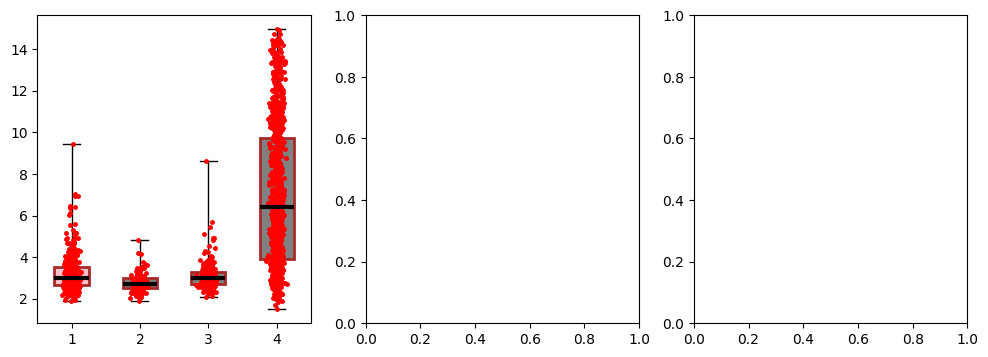

In [8]:
sex_name = ['female','male']
sex_color   = ['r','b']
fgtype_color = ['pink','grey', 'grey']
mgtype_color = ['skyblue','grey', 'grey']
gtype_color = [['pink','grey', 'grey'],['skyblue','grey', 'grey']]
# sex_color   = ['','']
gtype_marker = ['x','*','.']
event_name = ['HB','UWE','Lunge']

d_f1f2_m_R = np.nanmean(d_f1f2_HB[:,win_h-5:win_h],axis=1)



fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fontsize = 12
ms = 5
space = '                               '



scatter_d = 0.05
box_width = 0.5
edgelw = 2
i_Hz = 0 #1 Hz
n_gg_R = np.zeros((3,4)).astype(int)
distances_R = [[],[],[]]

exp_color = ['brown','orange']
# for i_Hz in range(speed_R72.shape[0]):


d_f1f2_m_R = np.nanmean(d_f1f2_HB[:,win_h-5:win_h],axis=1)
i_event  = 0
i_sex = 0
for j_gtype in [0,1,2]:

    c  = sex_color[i_sex]
    mt = gtype_marker[2]
    gender = (genders_status  ==i_sex)
    gtype  = (gytpe_f1f2_HB==j_gtype)
    n_R = np.sum(gtype)


    n_gg_R[i_event,j_gtype] = n_R

    axs[i_event].boxplot(d_f1f2_m_R[gtype], 
                         positions = [j_gtype+1], 
                         whis=(0, 100), widths = [box_width],
                         boxprops=dict(facecolor=gtype_color[i_sex][j_gtype],
                                       linewidth = edgelw, color=exp_color[0]),
                         medianprops = dict(color="black",linewidth=3),
                         vert=True, patch_artist=True)

    x = np.random.normal(j_gtype+1, scatter_d, size=n_R)
    axs[i_event].plot(x, d_f1f2_m_R[gtype], mt+c, ms=ms,)
    distances_R[i_event].append(d_f1f2_m_R[gtype])
    

d_f1f2_m_R = np.nanmean(d_f1f2_random_f[:,win_h-5:win_h],axis=1)
c  = sex_color[i_sex]
mt = gtype_marker[2]

n_R = len(d_f1f2_m_R)


n_gg_R[i_event,j_gtype] = n_R

axs[i_event].boxplot(d_f1f2_m_R, 
                     positions = [3+1], 
                     whis=(0, 100), widths = [box_width],
                     boxprops=dict(facecolor=gtype_color[i_sex][2],
                                   linewidth = edgelw, color=exp_color[0]),
                     medianprops = dict(color="black",linewidth=3),
                     vert=True, patch_artist=True)

x = np.random.normal(3+1, scatter_d, size=n_R)
axs[i_event].plot(x, d_f1f2_m_R, mt+c, ms=ms,)
distances_R[i_event].append(d_f1f2_m_R)

# d_f1f2_m_R = np.nanmean(d_f1f2_L[:,win_h-5:win_h],axis=1)
# i_event  = 1
# i_sex = 1
# for j_gtype in [0,1,2]:

#     c  = sex_color[i_sex]
#     mt = gtype_marker[2]
#     gender = (genders_status  ==i_sex)
#     gtype  = (gytpe_f1f2_L==j_gtype)
#     n_R = np.sum(gtype)


#     n_gg_R[i_event,j_gtype] = n_R

#     axs[i_event].boxplot(d_f1f2_m_R[gtype], 
#                          positions = [j_gtype+1], 
#                          whis=(0, 100), widths = [box_width],
#                          boxprops=dict(facecolor=gtype_color[i_sex][j_gtype],
#                                        linewidth = edgelw, color=exp_color[0]),
#                          medianprops = dict(color="black",linewidth=3),
#                          vert=True, patch_artist=True)

#     x = np.random.normal(j_gtype+1, scatter_d, size=n_R)
#     axs[i_event].plot(x, d_f1f2_m_R[gtype], mt+c, ms=ms,)
#     distances_R[i_event].append(d_f1f2_m_R[gtype])

# d_f1f2_m_R = np.nanmean(d_f1f2_UWE[:,win_h-5:win_h],axis=1)
# i_event  = 2
# i_sex = 1
# for j_gtype in [0,1,2]:

#     c  = sex_color[i_sex]
#     mt = gtype_marker[2]
#     gender = (genders_status  ==i_sex)
#     gtype  = (gytpe_f1f2_UWE==j_gtype)
#     n_R = np.sum(gtype)


#     n_gg_R[i_event,j_gtype] = n_R

#     axs[i_event].boxplot(d_f1f2_m_R[gtype], 
#                          positions = [j_gtype+1], 
#                          whis=(0, 100), widths = [box_width],
#                          boxprops=dict(facecolor=gtype_color[i_sex][j_gtype],
#                                        linewidth = edgelw, color=exp_color[0]),
#                          medianprops = dict(color="black",linewidth=3),
#                          vert=True, patch_artist=True)

#     x = np.random.normal(j_gtype+1, scatter_d, size=n_R)
#     axs[i_event].plot(x, d_f1f2_m_R[gtype], mt+c, ms=ms,)
#     distances_R[i_event].append(d_f1f2_m_R[gtype])
    
    

#         axs[i_sex].set_ylim([3,12])

#         yticks_label = [4,6,8,10,12]

#         xticks_R26R72 = [
#                       'R26E01-GAL4\nUAS-dTRPA1\nR72A10-GAL4\nn =',
#                       '+\n+\n-\n'+str(n_gg_R26[i_sex,0]),
#                       '+\n-\n-\n'+str(n_gg_R26[i_sex,1]),
#                       '-\n+\n-\n'+str(n_gg_R26[i_sex,2]),
#                       '-\n+\n+\n'+str(n_gg_R72[i_sex,0]),
#                       '-\n-\n+\n'+str(n_gg_R72[i_sex,1]),
#                       '-\n+\n-\n'+str(n_gg_R72[i_sex,2])
#                      ]
#         xticks_v = np.arange(7).astype(float)
#         xticks_v[0] = -0.2
#         axs[i_sex].set_xlim([xticks_v[0],7])
#         axs[i_sex].set_ylabel('fly pair distance:mm')
#         axs[i_sex].set_xticks(xticks_v, xticks_R26R72)
#         axs[i_sex].set_yticks(yticks_label, yticks_label)
#         axs[i_sex].spines['top'].set_visible(False)
#         axs[i_sex].spines['right'].set_visible(False)



# axs[0].plot([1,1,2,2,2,2,3,3],[0.73,0.75,0.75,0.73,0.73,0.75,0.75,0.73],'k',lw = 2)
# axs[0].text(2, 0.78, 'Kruskal-Wallis test: ns', #Kruskal-Wallis p-value: 0.1540
#         horizontalalignment='center',
#         verticalalignment='center',fontsize = fontsize)

# y_ps = [10.0,10.4,10.8,11.2,11.6]
# pvalues = ['****','**','**','*****','*']
# for i in range(len(y_ps)):

#     y_p = y_ps[i]
#     axs[0].plot([1,1,2+i,2+i],[y_p,y_p+0.1,y_p+0.1,y_p],'k')
#     axs[0].text(1.5+0.5*i, y_p+0.3, pvalues[i], #Dunn's test p = 0.002262 p< 0.005 **
#             horizontalalignment='center',
#             verticalalignment='center')


# y_ps = [10.8,10.4,10.0,11.2,11.6]
# pvalues = ['*','ns','*','**','ns']
# y_text = [1,2,3,5,6]
# for i in range(len(y_ps)):
#     y_p = y_ps[i]
#     axs[1].plot([4,4,y_text[i],y_text[i]],[y_p,y_p+0.1,y_p+0.1,y_p],'k')
#     axs[1].text((4+y_text[i])/2, y_p+0.3, pvalues[i], #Dunn's test p = 0.002262 p< 0.005 **
#             horizontalalignment='center',
#             verticalalignment='center')




# legend_elements = []
# legend_elements.append(Line2D([0], [0], marker=gtype_marker[2], color=sex_color[0], linestyle='None',ms = ms, 
#                                 label = sex_name[0]+' assay'))
                       
# legend_elements.append(Line2D([0], [0], marker=gtype_marker[2], color=sex_color[1], linestyle='None',ms = ms,
#                                 label = sex_name[1]+' assay'))


# legend_elements.append(Patch(facecolor=fgtype_color[0],
#                              label='experimental\ngroup '+sex_name[0]))
# legend_elements.append(Patch(facecolor=mgtype_color[0],
#                              label='experimental\ngroup '+sex_name[1]))
# legend_elements.append(Patch(facecolor=mgtype_color[1],
#                              label='control group'))

# legend_elements.append(Patch(edgecolor=exp_color[0],linewidth=edgelw,facecolor='none',
#                              label='R26E01\nexperiments'))
# legend_elements.append(Patch(edgecolor=exp_color[1],linewidth=edgelw,facecolor='none',
#                              label='R72A10\nexperiments'))


# axs[1].legend(handles=legend_elements, bbox_to_anchor=(1, 1))


In [30]:
# Example data (replace with your data)
# i_sex = 0
# group1 = distances_R[i_sex][0]
# group2 = distances_R[i_sex][1]
# group3 = distances_R[i_sex][2]
# print(i_sex,len(group1),len(group2),len(group3))
# nly.three_group_stat3(group1, 'HB', group2, "UWE", group3, 'lunge')
# print()


from scipy.stats import kruskal
import scikit_posthocs as sp

group1 = distances_R[0][0]
group2 = distances_R[0][1]
group3 = distances_R[0][2]
group4 = distances_R[0][3]

stat, p = kruskal(group1, group2, group3, group4)
print(f"Kruskal-Wallis test: Statistic = {stat:.3f}, p-value = {p:.3f}")
data = [group1, group2, group3, group4]
dunn_result = sp.posthoc_dunn(data, p_adjust='bonferroni')
print(dunn_result)


Kruskal-Wallis test: Statistic = 744.478, p-value = 0.000
              1             2             3             4
1  1.000000e+00  1.923458e-05  1.000000e+00  3.537668e-91
2  1.923458e-05  1.000000e+00  2.578824e-04  2.096510e-79
3  1.000000e+00  2.578824e-04  1.000000e+00  4.077767e-73
4  3.537668e-91  2.096510e-79  4.077767e-73  1.000000e+00
